# EE4375-2022: Fifth Lab Session: FEM-1D using Distributed Computing

Solves the Poisson equation $- \frac{d^2 \, u(x)}{dx^2} = f(x)$ on the unit bar domain $x \in \Omega=(0,1)$ supplied with various boundary conditions and various source terms. The Galerkin finite element method is employed. Here we target a distributed computing implementation. 

General info on [parallel computing in Julia](https://juliaparallel.org/resources/) and [MPI.jl](https://github.com/JuliaParallel/MPI.jl). 

![1D FEM sketch](./1D.jpg)

## Import Packages

In [1]:
using LinearAlgebra
using Plots
using LaTeXStrings
using SparseArrays
using BenchmarkTools
using SparseArrays
using Distributed
using SharedArrays
using IterativeSolvers

## Section 1: Preprocessing 
- <b> first approach </b>: monolithic in memory approach: assuming global mesh, matrix and rhs vector to be available on all processors: assembly process similar to all processors; 
- <b> second approach </b>: distribute memory approach: distribute memory approach: distributed assembly and solve; include figure here; 

![Splitting up the matrix](./matrix.jpg)

## Section 2: Construction of Matrix and Right-Hand Side Vector 
- <b> first approach </b>: using distributed for loop as in [distributed computing toolbox](https://docs.julialang.org/en/v1/stdlib/Distributed/); similar to Fresh-Approach example; 
- using pmap; see above; difference between for-loop and map might be matter of taste;
- using lazy_map (gridap like);
- <b> second approach </b>: using SharedVector and SharedMatrix using [shared arrays](https://docs.julialang.org/en/v1/stdlib/SharedArrays/); or [Distributed Arrays](https://juliaparallel.org/DistributedArrays.jl/stable/); each processor fills its part of the matrix; decomposition according to elements (as opposed to nodes); 
- using Partitioned Matrices 

### Original solution

In [2]:
#..construct the mesh: see before 
N = 100; h = 1/N; 
x = Vector(0:h:1); 

#..Mesh with points and edges 
#..point holds the coordinates of the left and right node of the element
#..edges holds the global indices of the left and right node of the element
points = collect( [x[i], x[i+1]] for i in 1:length(x)-1) 
edges = collect( [i, i+1] for i in 1:length(x)-1); 

#..Set the source function 
fsource(x) = x*(x-1); 

#..Initialize global matrix and right-hand side value 
A = zeros(length(x), length(x)); 
f = zeros(length(x), 1); 

#..Perform loop over elements and assemble global matrix and vector 
for i=1:length(edges) 

  xl, xr = points[i,:][1]
  floc = (xr-xl) * [fsource(xl) fsource(xr)];
  Aloc = (1/(xr-xl))*[1 -1; -1 1]; 

  for j=1:2 
    f[edges[i][j]] += floc[j];
    for k =1:2 
      A[edges[i][j], edges[i][k]] += Aloc[j,k]; 
    end 
  end 

end

f_orig = copy(f)
A_orig = copy(A);

### First Approach - map

In [3]:
A_map = zeros(length(x), length(x)); 
f_map = zeros(length(x), 1); 

function compose_A_and_f!(A, f, elem_id)
  xl, xr = points[elem_id,:][1]
  floc = (xr-xl) * [fsource(xl) fsource(xr)]
  Aloc = (1/(xr-xl))*[1 -1; -1 1]

  f[edges[elem_id,]] += floc[:]
  A[edges[elem_id,], edges[elem_id,]] += Aloc[:, :]
end 

map(elem_id -> compose_A_and_f!(A_map, f_map, elem_id), Vector(1:length(edges)))
println(f_orig ≈ f_map)
println(A_orig ≈ A_map)

true
true


### First Approach - pmap

In [4]:
while nprocs() < 3
    addprocs(1)
end
no_procs = nprocs()

@everywhere using Pkg
@everywhere Pkg.activate(".")

@everywhere N = 100
@everywhere h = 1/N
@everywhere x = Vector(0:h:1)
@everywhere fsource(x) = x*(x-1)

@everywhere points = collect( [x[i], x[i+1]] for i in 1:length(x)-1)
@everywhere edges = collect( [i, i+1] for i in 1:length(x)-1)

A_pmap = zeros(length(x), length(x)); 
f_pmap = zeros(length(x), 1); 

@everywhere function compose_A_and_f(elem_id)
  A = zeros(length(x), length(x))
  f = zeros(length(x), 1)
  
  xl, xr = points[elem_id,:][1]
  floc = (xr-xl) * [fsource(xl) fsource(xr)]
  Aloc = (1/(xr-xl))*[1 -1; -1 1]

  f[edges[elem_id,]] += floc[:]
  A[edges[elem_id,], edges[elem_id,]] += Aloc[:, :]
  return(A, f)
end 

results = pmap(elem_id -> compose_A_and_f(elem_id), Vector(1:length(edges)))
A_pmap, f_pmap = reduce(.+, results)

println("no_procs is ", no_procs)
println(f_orig ≈ f_pmap)
println(A_orig ≈ A_pmap)

      From worker 2:	  Activating new project at `C:\Users\sbranchett\work\finite_element_electrical_engineering\lab-sessions`
      From worker 3:	  Activating new project at `C:\Users\sbranchett\work\finite_element_electrical_engineering\lab-sessions`


  Activating new project at `C:\Users\sbranchett\work\finite_element_electrical_engineering\lab-sessions`


no_procs is 3
true
true


### First/Second Approach - pmap

In [5]:
while nprocs() < 3
    addprocs(1)
end
no_procs = nprocs()

@everywhere using Pkg
@everywhere Pkg.activate(".")

@everywhere N = 100
@everywhere h = 1/N
@everywhere x = Vector(0:h:1)
@everywhere fsource(x) = x*(x-1)

@everywhere points = collect( [x[i], x[i+1]] for i in 1:length(x)-1)
edges = collect( [i, i+1] for i in 1:length(x)-1)

A_pmap2 = zeros(length(x), length(x)); 
f_pmap2 = zeros(length(x), 1); 

@everywhere function contribution_A_and_f(elem_id)
  xl, xr = points[elem_id,:][1]
  floc = (xr-xl) * [fsource(xl) fsource(xr)]
  Aloc = (1/(xr-xl))*[1 -1; -1 1]
  return Aloc, floc
end

contributions = pmap(elem_id -> contribution_A_and_f(elem_id), Vector(1:length(edges)))
for elem_id=1:length(edges) 
  f_pmap2[edges[elem_id,]] += contributions[elem_id][2][:]
  A_pmap2[edges[elem_id,], edges[elem_id,]] += contributions[elem_id][1][:, :]
end
println("no_procs is ", no_procs)
println(f_orig ≈ f_pmap2)
println(A_orig ≈ A_pmap2)

      From worker 2:	  Activating new project at `C:\Users\sbranchett\work\finite_element_electrical_engineering\lab-sessions`
      From worker 3:	  Activating new project at `C:\Users\sbranchett\work\finite_element_electrical_engineering\lab-sessions`


  Activating new project at `C:\Users\sbranchett\work\finite_element_electrical_engineering\lab-sessions`


no_procs is 3
true
true


### Second approach - Shared Arrays

In [6]:
while nprocs() < 3
    addprocs(1)
end
no_procs = nprocs()

@everywhere using Pkg
@everywhere Pkg.activate(".")

@everywhere N = 100
@everywhere h = 1/N
@everywhere x = Vector(0:h:1)
@everywhere fsource(x) = x*(x-1)

@everywhere points = collect( [x[i], x[i+1]] for i in 1:length(x)-1)
@everywhere edges = collect( [i, i+1] for i in 1:length(x)-1)

A_shared = SharedArray{Float64}(length(x), length(x))
f_shared = SharedArray{Float64}(length(x), 1)

# initialise the data matrix with dummy values
for ii=1:length(f_shared)
   f_shared[ii] = 0.
end
for ii=1:length(A_shared)
   A_shared[ii] = 0.
end

@everywhere function shared_A_and_f!(elem_id, A, f)
  xl, xr = points[elem_id,:][1]
  floc = (xr-xl) * [fsource(xl) fsource(xr)]
  Aloc = (1/(xr-xl))*[1 -1; -1 1]

  f[edges[elem_id,]] += floc[:]
  A[edges[elem_id,], edges[elem_id,]] += Aloc[:, :]
end

for elem_id=1:length(edges)
    fetch(@spawn shared_A_and_f!(elem_id, A_shared, f_shared))
end

println("no_procs is ", no_procs)
println(f_orig ≈ f_shared)
println(A_orig ≈ A_shared)

      From worker 3:	  Activating new project at `C:\Users\sbranchett\work\finite_element_electrical_engineering\lab-sessions`
      From worker 2:	  Activating new project at `C:\Users\sbranchett\work\finite_element_electrical_engineering\lab-sessions`


  Activating new project at `C:\Users\sbranchett\work\finite_element_electrical_engineering\lab-sessions`


no_procs is 3
true
true


## Section 3: Linear System Solve 
- <b> first approach </b>: use backslash (nothing to be done); 
- using sequential preconditioned [conjugate gradient method](https://en.wikipedia.org/wiki/Conjugate_gradient_method) from [IterativeSolvers.jl](https://github.com/JuliaLinearAlgebra/IterativeSolvers.jl)
- <b> second approach </b>: use preconditioned conjugate gradient method; using parallel BLAS1 and BLAS2 functions; using [sparse-matrix multiplication](https://github.com/JuliaInv/ParSpMatVec.jl);
- use PCG with proper overlap of computation and communication; 

In [7]:
#..handle the boundary conditions in the matrix and right-hand side vector 
A[1,1] = 1;     A[1,2] = 0;        f[1]   = 0; 
A[end,end-1]=0; A[end,end] = 1;    f[end] = 0;

### First Approach - backslash

In [8]:
#..solve the linear system
u = A \ f;

### First Approach - conjugate gradient

In [14]:
u_cg = IterativeSolvers.cg(A, f)
println(u ≈ u_cg)

true


### Second Approach - // conjugate gradient

In [21]:
while nprocs() < 3
    addprocs(1)
end
no_procs = nprocs()

@everywhere using Pkg
@everywhere Pkg.activate(".")

@everywhere N = 100
@everywhere h = 1/N
@everywhere x = Vector(0:h:1)

@everywhere function one_row_cg(elem_id, A_shared, f_shared)
  f = zeros(length(x), 1)
  f[elem_id] = f_shared[elem_id]
  
  u_elem = A_shared \ f
  
  println(u_elem)
  return(u_elem)
end 

results = pmap(elem_id -> one_row_cg(elem_id, A_shared, f_shared), Vector(1:length(edges)))
u_pmap = reduce(.+, results)

println("no_procs is ", no_procs)
println(u ≈ u_pmap)

      From worker 3:	  Activating project at `C:\Users\sbranchett\work\finite_element_electrical_engineering\lab-sessions`
      From worker 2:	  Activating project at `C:\Users\sbranchett\work\finite_element_electrical_engineering\lab-sessions`


  Activating project at `C:\Users\sbranchett\work\finite_element_electrical_engineering\lab-sessions`


      From worker 3:	[0.0; 0.0; -0.0; -0.0; -0.0; -0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0;;]
      From worker 2:	[-1.5481123719084594e9; -1.5481123719084594e9; -1.5481123719084578e9; -1.548112371908456e9; -1.5481123719084544e9; -1.548112371908453e9; -1.5481123719084516e9; -1.54811237190845e9; -1.5481123719084482e9; -1.5481123719084468e9; -1.5481123719084454e9; -1.5481123719084437e9; -1.548112371908442e9; -1.5481123719084404e9; -1.5481123719084387e9; -1.5481123719084373e9; -1.548112371908436e9; -1.5481123719084349e9; -1.5481123719084342e9; -1.54811237190

## Section 4: Postprocessing 
Visualize the computed solution. 

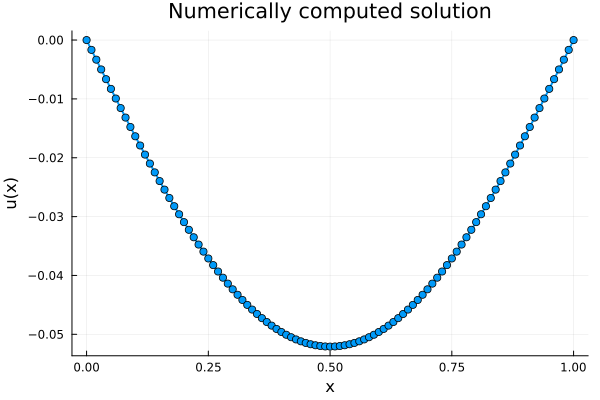

In [11]:
#..plot the solution  
p1=plot(x,u,shape=:circle,lw=2,legend=false)
xlabel!("x") 
ylabel!("u(x)")
title!("Numerically computed solution")